In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import os

sns.set_context("notebook", font_scale=1.25)
sns.color_palette("colorblind")
sns.set(font_scale=2)
sns.set_style("whitegrid")

## References

In [2]:
reference = json.load(open('../../references/sars_cov_2.json'))

In [3]:
reference.keys()

dict_keys(['genes', 'division', 'species_id', 'dbname', 'reference', 'genebuild', 'GO_genome', 'id', 'organism', 'assembly'])

In [5]:
genes = []
domains = []
for g in reference.get('genes'):
    for p in range(int(g.get('start')), int(g.get('end'))):
        genes.append((g.get('name'), p))
    for f in g.get('transcripts')[0].get('translations')[0].get('protein_features'):
        if f.get('dbname') == 'Pfam':
            for p in range(int(g.get('start')) + int(f.get('start')), int(g.get('start')) + int(f.get('end'))):
                domains.append((f.get('description'), p))
            
genes_df = pd.DataFrame(data=genes, columns=['gene', 'position'])
domains_df = pd.DataFrame(data=domains, columns=['domain', 'position'])

In [6]:
genes_df.head()

,gene,position
0,S,21563
1,S,21564
2,S,21565
3,S,21566
4,S,21567


In [7]:
domains_df.head()

,domain,position
0,CoV_S2,22274
1,CoV_S2,22275
2,CoV_S2,22276
3,CoV_S2,22277
4,CoV_S2,22278


In [8]:
def annotate_variants(variants, annotations):
    return pd.merge(variants, annotations, on='position')

## Data loading

In [9]:
data_folder = "../../data/db_dump_20221028/"

In [12]:
samples = pd.read_csv(os.path.join(data_folder, 'sample_ena.csv.gz'), compression='infer')
samples.head()

,run_accession,finished,sample_accession,scientific_name,study_accession,experiment_accession,first_created,collection_date,instrument_platform,instrument_model,...,percent_duplication,unpaired_reads_examined,read_pairs_examined,secondary_or_supplementary_reads,unmapped_reads,unpaired_read_duplicates,read_pair_duplicates,read_pair_optical_duplicates,covigator_accessor_version,covigator_processor_version
0,SRR12980395,NaN,SAMN16662808,Severe acute respiratory syndrome coronavirus 2,PRJNA631061,SRX9432021,2020-11-05,2020-03-17,ILLUMINA,Illumina MiSeq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.0.0.dev1
1,SRR16641660,NaN,SAMN22787387,Severe acute respiratory syndrome coronavirus 2,PRJNA776394,SRX12842354,2021-11-01,2020-12-30,ILLUMINA,Illumina iSeq 100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.0.0.dev1
2,SRR17817451,NaN,SAMN25378633,Severe acute respiratory syndrome coronavirus 2,PRJNA754449,SRX13979433,2022-01-30,2020-11-02,ILLUMINA,Illumina MiSeq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.0.0.dev1
3,SRR13009456,NaN,SAMN16707359,Severe acute respiratory syndrome coronavirus 2,PRJNA662193,SRX9460840,2020-11-10,2020-08-02,ILLUMINA,Illumina NovaSeq 6000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.0.0.dev1
4,ERR8955642,NaN,SAMEA10200158,Severe acute respiratory syndrome coronavirus 2,PRJEB43828,ERX8501012,2022-02-25,2021-09-08,ILLUMINA,Illumina NovaSeq 6000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,v1.0.0.dev1,v1.0.0.dev1


In [13]:
samples.columns

Index(['run_accession', 'finished', 'sample_accession', 'scientific_name',
       'study_accession', 'experiment_accession', 'first_created',
       'collection_date', 'instrument_platform', 'instrument_model',
       'library_name', 'nominal_length', 'library_layout', 'library_strategy',
       'library_source', 'library_selection', 'read_count', 'base_count',
       'sample_collection', 'sequencing_method', 'center_name', 'fastq_ftp',
       'fastq_md5', 'num_fastqs', 'host_tax_id', 'host_sex', 'host_body_site',
       'host_gravidity', 'host_phenotype', 'host_genotype', 'lat', 'lon',
       'country_raw', 'country', 'country_alpha_2', 'country_alpha_3',
       'continent', 'continent_alpha_2', 'count_snvs', 'count_insertions',
       'count_deletions', 'count_subclonal_snvs', 'count_subclonal_insertions',
       'count_subclonal_deletions', 'count_low_frequency_snvs',
       'count_low_frequency_insertions', 'count_low_frequency_deletions',
       'status', 'created_at', 'queued_at'

In [14]:
# filter out unfinished samples
samples = samples[samples.status == 'FINISHED']
samples.shape

(130941, 100)

In [15]:
num_samples = samples.shape[0]

In [16]:
subclonal_variants = pd.read_csv(os.path.join(data_folder, 'subclonal_variant_observation.csv.gz'), compression='infer')
subclonal_variants.head()

,sample,variant_id,chromosome,position,reference,alternate,quality,filter,dp,ac,...,variant_type,length,reference_amino_acid,alternate_amino_acid,position_amino_acid,cons_hmm_sars_cov_2,cons_hmm_sarbecovirus,cons_hmm_vertebrate_cov,pfam_name,pfam_description
0,ERR10161098,241:C>T,MN908947.3,241,C,T,157,SUBCLONAL,10,5,...,SNV,0,NaN,NaN,NaN,-1.25436,-1.25436,0.00000,NaN,NaN
1,ERR10161098,670:T>G,MN908947.3,670,T,G,160,SUBCLONAL,10,5,...,SNV,0,S,R,135.0,-0.72927,0.00000,-0.72927,bCoV_NSP1,"Non-structural protein NSP1, betacoronavirus"
2,ERR10161098,2470:C>T,MN908947.3,2470,C,T,52,SUBCLONAL,17,2,...,SNV,0,NaN,NaN,NaN,-1.04511,-1.04511,0.00000,CoV_NSP2_C,"Coronavirus replicase NSP2, C-terminal"
3,ERR10161098,7512:A>AT,MN908947.3,7512,A,AT,63,SUBCLONAL,20,2,...,INSERTION,1,NaN,NaN,NaN,0.57215,0.57215,0.00000,CoV_NSP3_C,"Coronavirus replicase NSP3, C-terminal"
4,ERR10161098,10447:G>A,MN908947.3,10447,G,A,264,SUBCLONAL,13,8,...,SNV,0,NaN,NaN,NaN,-1.04511,-1.04511,-0.72839,Peptidase_C30,"Peptidase C30, coronavirus"


In [1]:
subclonal_variants.shape

NameError: name 'subclonal_variants' is not defined

In [ ]:
low_frequency_variants = pd.read_csv(os.path.join(data_folder, 'low_frequency_variant_observation.csv.gz'), compression='infer')
low_frequency_variants.head()

In [ ]:
low_frequency_variants.shape

In [ ]:
variants = pd.concat([low_frequency_variants, subclonal_variants])

In [ ]:
variants.columns

In [ ]:
variants = annotate_variants(variants=variants, annotations=genes_df)

In [ ]:
variants = annotate_variants(variants=variants, annotations=domains_df)

## Evaluate dataset

In [66]:
def calculate_dist(samples, variants):
    # we take into account samples here to make sure the median includes samples with 0 intrahost
    count_per_sample = pd.merge(variants[['sample', 'variant_id']].groupby('sample').count().reset_index(), samples.run_accession, left_on='sample', right_on='run_accession', how='outer').fillna(0).variant_id
    return count_per_sample.median(), count_per_sample.quantile(0.25), count_per_sample.quantile(0.75)


def calculate_inframe_fs_ratio(variants):
    return variants[variants.annotation_highest_impact.isin(['conservative_inframe_deletion', 'disruptive_inframe_deletion', 'conservative_inframe_insertion', 'disruptive_inframe_insertion'])].shape[0] / \
          variants[variants.annotation_highest_impact == 'frameshift_variant'].shape[0]

    
def calculate_ns_s_ratio(variants):
    return variants[variants.annotation_highest_impact.isin(['missense_variant', 'stop_lost', 'stop_gained', 'start_lost'])].shape[0] / variants[variants.annotation_highest_impact == 'synonymous_variant'].shape[0]



In [61]:
variants.annotation_highest_impact.unique()

array(['frameshift_variant', 'conservative_inframe_deletion',
       'missense_variant', 'conservative_inframe_insertion',
       'synonymous_variant', 'stop_gained', 'disruptive_inframe_deletion',
       'disruptive_inframe_insertion', 'start_lost', 'stop_lost',
       'gene_fusion'], dtype=object)

In [71]:
def evaluate_dataset(samples, variants):
    
    print("Samples: %s" % samples.shape[0])
    
    print("-----")
    print("Intrahost mutations: %s" % variants.shape[0])
    print("Intrahost SNVs: %s" % variants[variants.variant_type == 'SNV'].shape[0])
    print("Intrahost insertions: %s" % variants[variants.variant_type == 'INSERTION'].shape[0])
    print("Intrahost deletions: %s" % variants[variants.variant_type == 'DELETION'].shape[0])
    
    print("-----")
    print("Unique intrahost mutations: %s" % variants.variant_id.unique().shape[0])
    print("Unique intrahost SNVs: %s" % variants[variants.variant_type == 'SNV'].variant_id.unique().shape[0])
    print("Unique intrahost insertions: %s" % variants[variants.variant_type == 'INSERTION'].variant_id.unique().shape[0])
    print("Unique intrahost deletions: %s" % variants[variants.variant_type == 'DELETION'].variant_id.unique().shape[0])
    
    print("-----")
    median, lower_quartile, upper_quartile = calculate_dist(variants=variants, samples=samples)
    print("Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): %s [%s, %s]" % (median, lower_quartile, upper_quartile))
    median, lower_quartile, upper_quartile = calculate_dist(variants=variants[variants.variant_type == 'SNV'], samples=samples)
    print("Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): %s [%s, %s]" % (median, lower_quartile, upper_quartile))
    median, lower_quartile, upper_quartile = calculate_dist(variants=variants[variants.variant_type == 'INSERTION'], samples=samples)
    print("Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): %s [%s, %s]" % (median, lower_quartile, upper_quartile))
    median, lower_quartile, upper_quartile = calculate_dist(variants=variants[variants.variant_type == 'DELETION'], samples=samples)
    print("Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): %s [%s, %s]" % (median, lower_quartile, upper_quartile))
    
    print("-----")
    print("Median VAF: %s" % variants.vaf.median())
    print("Median AC: %s" % variants.ac.median())
    print("Median DP: %s" % variants.dp.median())
    
    
    print("-----")
    print("Ratio of NS/S: %s" % (round(calculate_ns_s_ratio(variants), 3)))
    print("Ratio of in-frame/frameshift: %s" % (round(calculate_inframe_fs_ratio(variants), 3)))
    print("Stop loss: %s" % variants[variants.annotation_highest_impact == 'stop_lost'].shape[0])
    print("Stop gained: %s" % variants[variants.annotation_highest_impact == 'stop_gained'].shape[0])
    print("Start loss: %s" % variants[variants.annotation_highest_impact == 'start_lost'].shape[0])
    
    print("-----")
    print("Variant calling quality: %s" % variants.quality.median())
    print("SNVs: %s" % variants[variants.variant_type == 'SNV'].quality.median())
    print("Insertion: %s" % variants[variants.variant_type == 'INSERTION'].quality.median())
    print("Deletion: %s" % variants[variants.variant_type == 'DELETION'].quality.median())
    
    print("-----")
    print("Entropy genomic positions: %s" % variants.position.transform(lambda p: p * np.log(p)).sum())
    print("SNVs: %s" % variants[variants.variant_type == 'SNV'].position.transform(lambda p: p * np.log(p)).sum())
    print("Insertions: %s" % variants[variants.variant_type == 'INSERTION'].position.transform(lambda p: p * np.log(p)).sum())
    print("Deletions: %s" % variants[variants.variant_type == 'DELETION'].position.transform(lambda p: p * np.log(p)).sum())

In [68]:
evaluate_dataset(samples=samples, variants=variants)

Samples: 130941
-----
Intrahost mutations: 16299588
Intrahost SNVs: 7289141
Intrahost insertions: 3735469
Intrahost deletions: 5274978
-----
Unique intrahost mutations: 60811
Unique intrahost SNVs: 23561
Unique intrahost insertions: 14344
Unique intrahost deletions: 22906
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 82.0 [39.0, 148.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 24.0 [10.0, 60.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 11.0 [4.0, 37.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 27.0 [11.0, 52.0]
-----
Median VAF: 0.005900870077311993
Median AC: 8.0
Median DP: 1652.0
-----
Ratio of NS/S: 2.514
Ratio of in-frame/frameshift: 0.098
Stop loss: 773
Stop gained: 293707
Start loss: 5386
-----
Variant calling quality: 94.0
SNVs: 114.0
Insertion: 83.0
Deletion: 78.0
-----
Entropy genomic positions: 872687

In [69]:
evaluate_dataset(samples=samples, variants=subclonal_variants)

Samples: 130941
-----
Intrahost mutations: 2464922
Intrahost SNVs: 1556312
Intrahost insertions: 636643
Intrahost deletions: 271967
-----
Unique intrahost mutations: 126892
Unique intrahost SNVs: 78263
Unique intrahost insertions: 15872
Unique intrahost deletions: 32757
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 5.0 [2.0, 10.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 3.0 [1.0, 7.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 1.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 1.0 [0.0, 3.0]
-----
Median VAF: 0.14285700023174286
Median AC: 2.0
Median DP: 21.0
-----
Ratio of NS/S: 2.503
Ratio of in-frame/frameshift: 0.107
Stop loss: 18966
Stop gained: 44645
Start loss: 1833
-----
Variant calling quality: 68.0
SNVs: 115.0
Insertion: 66.0
Deletion: 324.0
-----
Entropy genomic positions: 384382503302.6119
SN

In [80]:
def evaluate_dataset_by_gene_domain(variants):
    
    print("-----")
    print("Ratio of NS/S: %s" % (round(calculate_ns_s_ratio(variants), 3)))
    for g in variants.gene.unique():
        print("Ratio of NS/S in gene %s: %s" % (g, round(calculate_ns_s_ratio(variants[variants.gene == g]), 3)))
    for d in variants[variants.gene == 'S'].domain.unique():
        print("Ratio of NS/S in domain %s: %s" % (d, round(calculate_ns_s_ratio(variants[variants.domain == d]), 3)))
    
    print("-----")
    print("Ratio of in-frame/frameshift: %s" % (round(calculate_inframe_fs_ratio(variants), 3)))
    for g in variants.gene.unique():
        print("Ratio of in-frame/frameshift in gene %s: %s" % (g, round(calculate_inframe_fs_ratio(variants[variants.gene == g]), 3)))
    for d in variants[variants.gene == 'S'].domain.unique():
        print("Ratio of in-frame/frameshift in domain %s: %s" % (d, round(calculate_inframe_fs_ratio(variants[variants.domain == d]), 3)))

In [81]:
evaluate_dataset_by_gene_domain(variants)

-----
Ratio of NS/S: 2.514
Ratio of NS/S in gene ORF1ab: 2.491
Ratio of NS/S in gene S: 2.596
Ratio of NS/S in gene M: 4.576
Ratio of NS/S in gene ORF8: 3.117
Ratio of NS/S in gene N: 2.47
Ratio of NS/S in gene ORF3a: 1.853
Ratio of NS/S in gene E: 3.509
Ratio of NS/S in gene ORF7a: 3.599
Ratio of NS/S in gene ORF7b: 2.34
Ratio of NS/S in gene ORF6: 1.522
Ratio of NS/S in domain bCoV_S1_RBD: 4.682
Ratio of NS/S in domain CoV_S2: 3.263
Ratio of NS/S in domain CoV_S1_C: 3.501
Ratio of NS/S in domain bCoV_S1_N: 1.529
-----
Ratio of in-frame/frameshift: 0.098
Ratio of in-frame/frameshift in gene ORF1ab: 0.099
Ratio of in-frame/frameshift in gene S: 0.136
Ratio of in-frame/frameshift in gene M: 0.026
Ratio of in-frame/frameshift in gene ORF8: 0.007
Ratio of in-frame/frameshift in gene N: 0.181
Ratio of in-frame/frameshift in gene ORF3a: 0.032
Ratio of in-frame/frameshift in gene E: 0.088
Ratio of in-frame/frameshift in gene ORF7a: 0.018
Ratio of in-frame/frameshift in gene ORF7b: 0.029
Rati

## Sample filtering

In [16]:
samples[['library_strategy', 'run_accession']].groupby('library_strategy').count()

,run_accession
library_strategy,
Targeted-Capture,12945
WGA,72176
WGS,45820


In [17]:
samples[samples['num_reads'].isna()].shape

(0, 100)

### Filter by number of reads as a proxy for viral load

The best proxy for viral load is PCR Ct, but we don't have that information. As an alternative Valesano and Sapoval used the total number of uniquely mapped reads (thresholds of 50,000 and 20,000 reads respectively). Here we will use the total number of reads which will be less conservative.

In [18]:
samples[['num_reads', 'library_strategy']].groupby('library_strategy').mean()

,num_reads
library_strategy,
Targeted-Capture,105766.259251
WGA,524534.631886
WGS,493458.609057


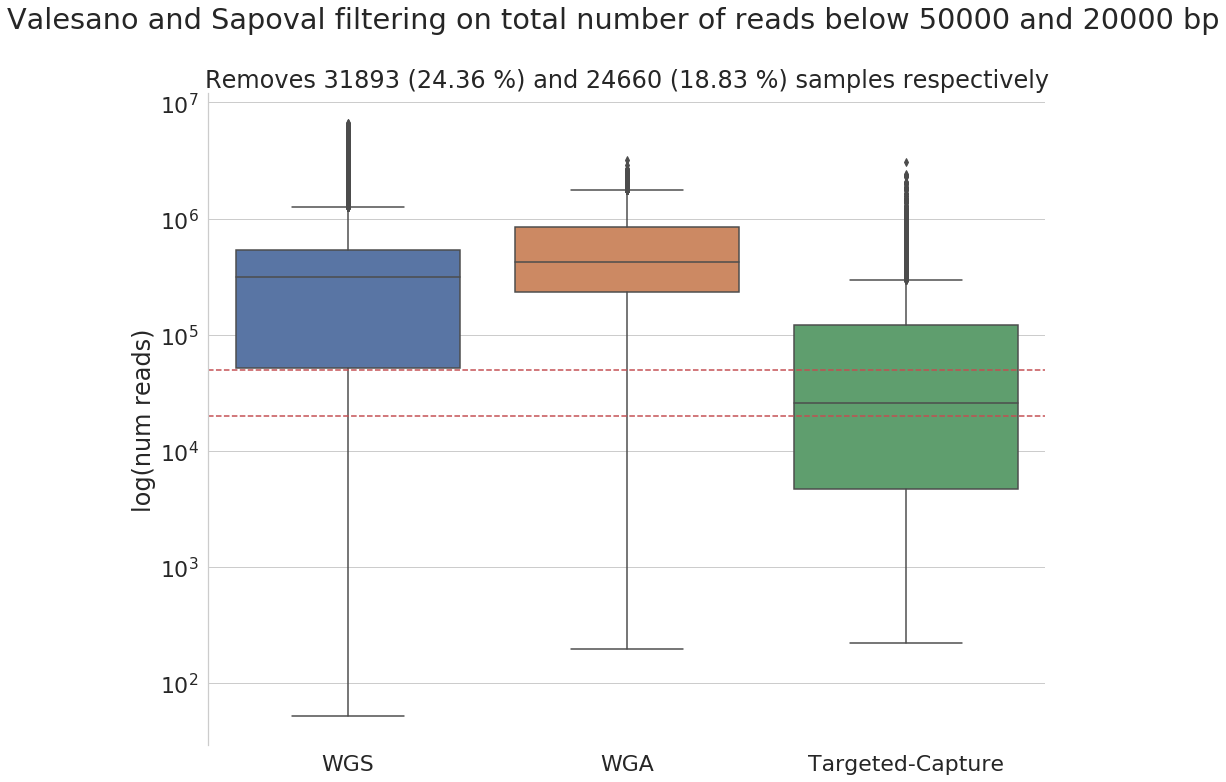

In [19]:
filter_num_reads_1 = 50000
filter_num_reads_2 = 20000

plt.figure(figsize=(15, 12))
sns.boxplot(data=samples, x='library_strategy', y='num_reads')
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('log(num reads)')
plt.axhline(filter_num_reads_1, c='r', linestyle='--')
plt.axhline(filter_num_reads_2, c='r', linestyle='--')
plt.suptitle("Valesano and Sapoval filtering on total number of reads below {} and {} bp".format(filter_num_reads_1, filter_num_reads_2))
num_filterd_samples_1 = samples[samples.num_reads < filter_num_reads_1].shape[0]
num_filterd_samples_2 = samples[samples.num_reads < filter_num_reads_2].shape[0]
plt.title("Removes {} ({} %) and {} ({} %) samples respectively".format(num_filterd_samples_1, round(float(num_filterd_samples_1) / num_samples * 100, 2), num_filterd_samples_2, round(float(num_filterd_samples_2) / num_samples * 100, 2)))
sns.despine(bottom=True)

### Filter by horizontal coverage

Valesano applies a filter of a consensus sequence of at least 29,000 bp. Popa applies a a filter on 96 % of genome coverage. Others combine horizontal coverage with mean depth of coverage. Here we apply two filters at 29,000 bp covered.

In [20]:
samples[['covered_bases', 'library_strategy']].groupby('library_strategy').mean()

,covered_bases
library_strategy,
Targeted-Capture,29236.836076
WGA,29766.462855
WGS,29516.085378


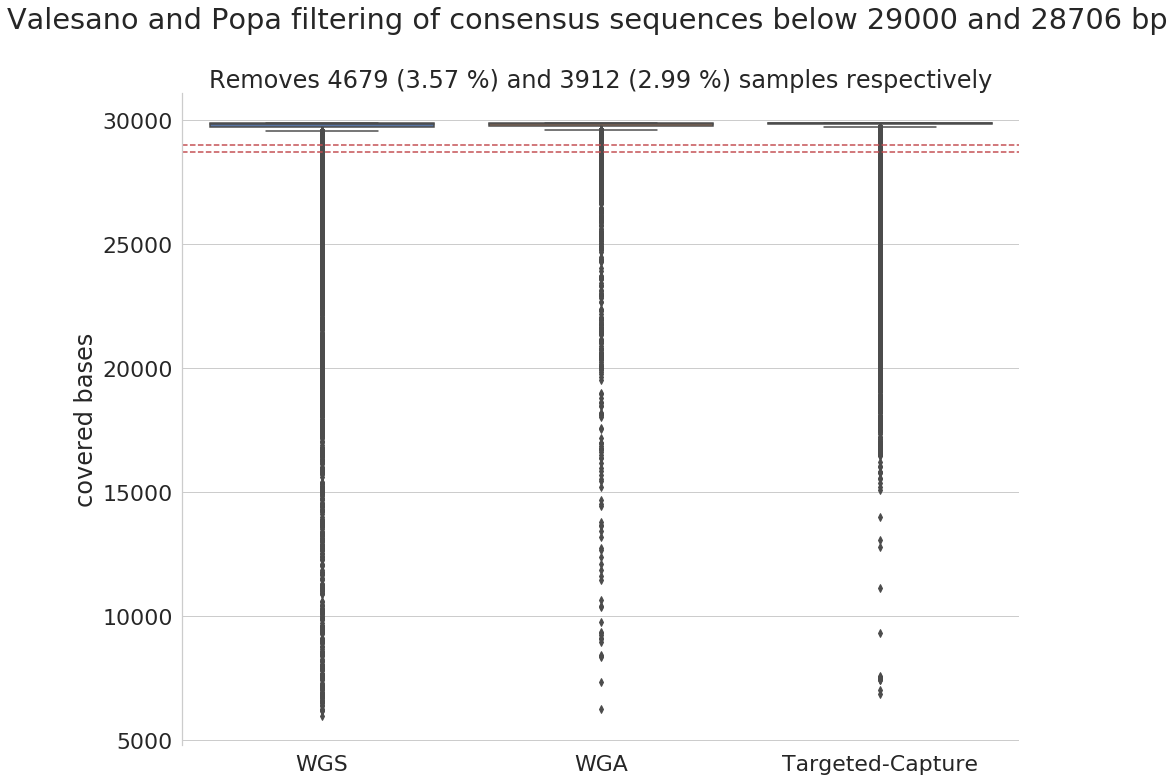

In [21]:
filter_covered_bases_thr = 29000
total_length = 29903
filter_covered_bases_thr_2 = int(29903 * 0.96)

plt.figure(figsize=(15, 12))
sns.boxplot(data=samples, x='library_strategy', y='covered_bases')
plt.xlabel(None)
plt.ylabel('covered bases')
plt.axhline(filter_covered_bases_thr, c='r', linestyle='--')
plt.axhline(filter_covered_bases_thr_2, c='r', linestyle='--')
plt.suptitle("Valesano and Popa filtering of consensus sequences below {} and {} bp".format(filter_covered_bases_thr, filter_covered_bases_thr_2))
num_filterd_samples = samples[samples.covered_bases < filter_covered_bases_thr].shape[0]
num_filterd_samples_2 = samples[samples.covered_bases < filter_covered_bases_thr_2].shape[0]
plt.title("Removes {} ({} %) and {} ({} %) samples respectively".format(num_filterd_samples, round(float(num_filterd_samples) / num_samples * 100, 2), num_filterd_samples_2, round(float(num_filterd_samples_2) / num_samples * 100, 2)))
sns.despine(bottom=True)

In [22]:
samples[['library_strategy', 'coverage']].groupby('library_strategy').mean()

,coverage
library_strategy,
Targeted-Capture,97.772252
WGA,99.543399
WGS,98.706100


### Filter by vertical coverage

Wang applies a hard filter on 60x mean coverage. Here we compare the impact of multiple thresholds.

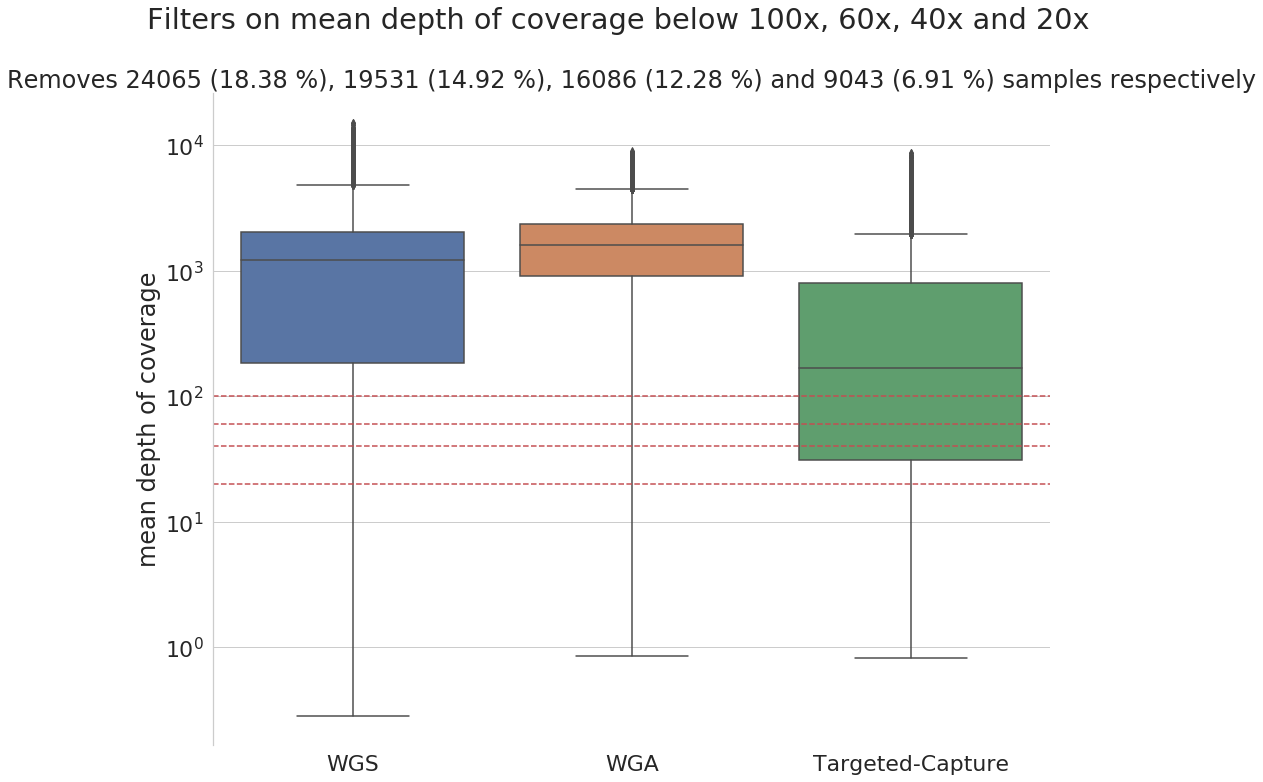

In [23]:
filter_mean_coverage_thr_1 = 100
filter_mean_coverage_thr_2 = 60
filter_mean_coverage_thr_3 = 40
filter_mean_coverage_thr_4 = 20


plt.figure(figsize=(15, 12))
sns.boxplot(data=samples, x='library_strategy', y='mean_depth')
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('mean depth of coverage')
plt.axhline(filter_mean_coverage_thr_1, c='r', linestyle='--')
plt.axhline(filter_mean_coverage_thr_2, c='r', linestyle='--')
plt.axhline(filter_mean_coverage_thr_3, c='r', linestyle='--')
plt.axhline(filter_mean_coverage_thr_4, c='r', linestyle='--')

plt.suptitle("Filters on mean depth of coverage below 100x, 60x, 40x and 20x")
num_filterd_samples_1 = samples[samples.mean_depth < filter_mean_coverage_thr_1].shape[0]
num_filterd_samples_2 = samples[samples.mean_depth < filter_mean_coverage_thr_2].shape[0]
num_filterd_samples_3 = samples[samples.mean_depth < filter_mean_coverage_thr_3].shape[0]
num_filterd_samples_4 = samples[samples.mean_depth < filter_mean_coverage_thr_4].shape[0]
plt.title("Removes {} ({} %), {} ({} %), {} ({} %) and {} ({} %) samples respectively".format(
    num_filterd_samples_1, round(float(num_filterd_samples_1) / num_samples * 100, 2), 
    num_filterd_samples_2, round(float(num_filterd_samples_2) / num_samples * 100, 2), 
    num_filterd_samples_3, round(float(num_filterd_samples_3) / num_samples * 100, 2), 
    num_filterd_samples_4, round(float(num_filterd_samples_4) / num_samples * 100, 2)))
sns.despine(bottom=True)

### Filter by excess of low frequency variants

In [24]:
data = pd.merge(variants, samples[['run_accession', 'library_strategy']], left_on='sample', right_on='run_accession', how='outer')[['library_strategy', 'run_accession', 'variant_id']].groupby(['library_strategy', 'run_accession']).count().reset_index()

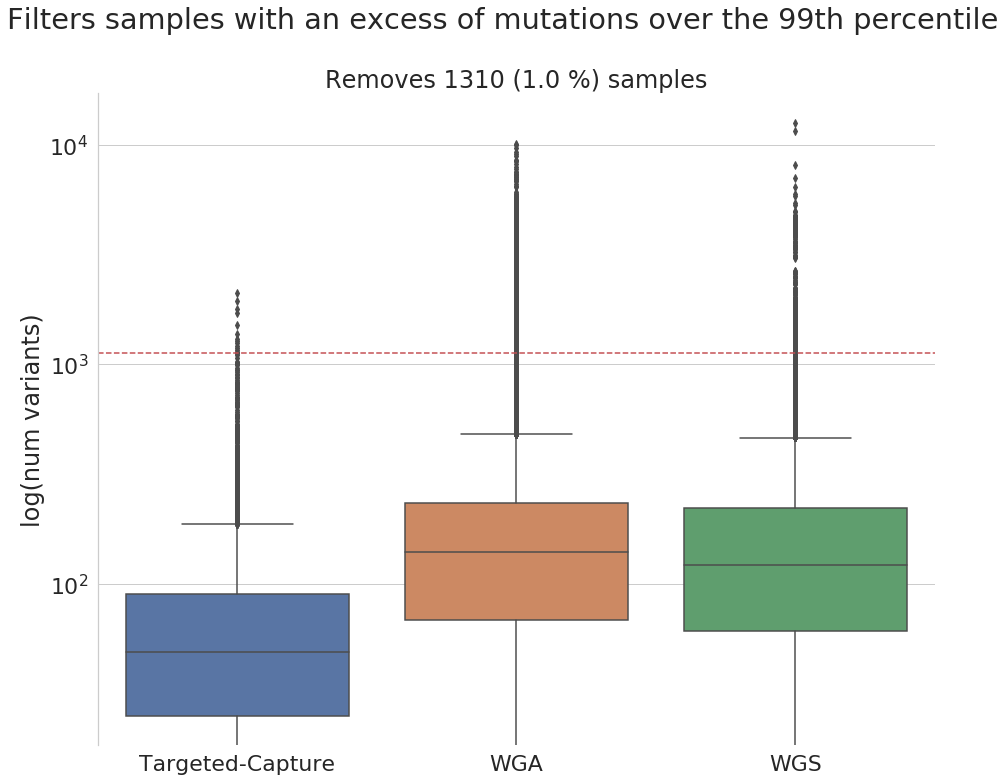

In [25]:
filter_excess_mutations_thr = data.variant_id.quantile(0.99)

plt.figure(figsize=(15, 12))
sns.boxplot(data=data, x='library_strategy', y='variant_id')
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('log(num variants)')
plt.axhline(filter_excess_mutations_thr, c='r', linestyle='--')

plt.suptitle("Filters samples with an excess of mutations over the 99th percentile")
num_filterd_samples = data[data.variant_id > filter_excess_mutations_thr].shape[0]
plt.title("Removes {} ({} %) samples".format(
    num_filterd_samples, round(float(num_filterd_samples) / num_samples * 100, 2)))
sns.despine(bottom=True)

### Identify co-infected samples

In (Tonkin-Hall, 2020) they identify samples co-infected by different SARS-CoV-2 lineages using a linear model to identify those samples' mutations better explained by a combination of two SARS-Cov-2 lineages. 
They aim at filtering out those samples as they contain mutations with iSNV-looking VAFs derived from the co-infection.
Here we use the number of mutations per sample with a VAF between 40 % and 80 % as a proxy for co-infection. We filter out those samples with an outlier number of these mid-VAF mutations.

Furthermore, most of these samples have low horizontal coverage and read count values.

In [26]:
count_variants_per_sample = pd.merge(
    variants[(variants.vaf > 0.4) & (variants.vaf < 0.6)], 
    samples[['run_accession', 'library_strategy']], 
    left_on='sample', right_on='run_accession', how='outer')[['library_strategy', 'run_accession', 'variant_id']]\
.groupby(['library_strategy', 'run_accession']).count().reset_index()

In [27]:
count_variants_per_sample.variant_id.median()

0.0

In [28]:
#outlier_thr = count_variants_per_sample.variant_id.median() + (2 * (count_variants_per_sample.variant_id.quantile(0.75) - count_variants_per_sample.variant_id.quantile(0.25)))
outlier_thr = 10
outlier_thr

10

In [29]:
count_variants_per_sample[count_variants_per_sample.variant_id > outlier_thr].shape[0]

1050

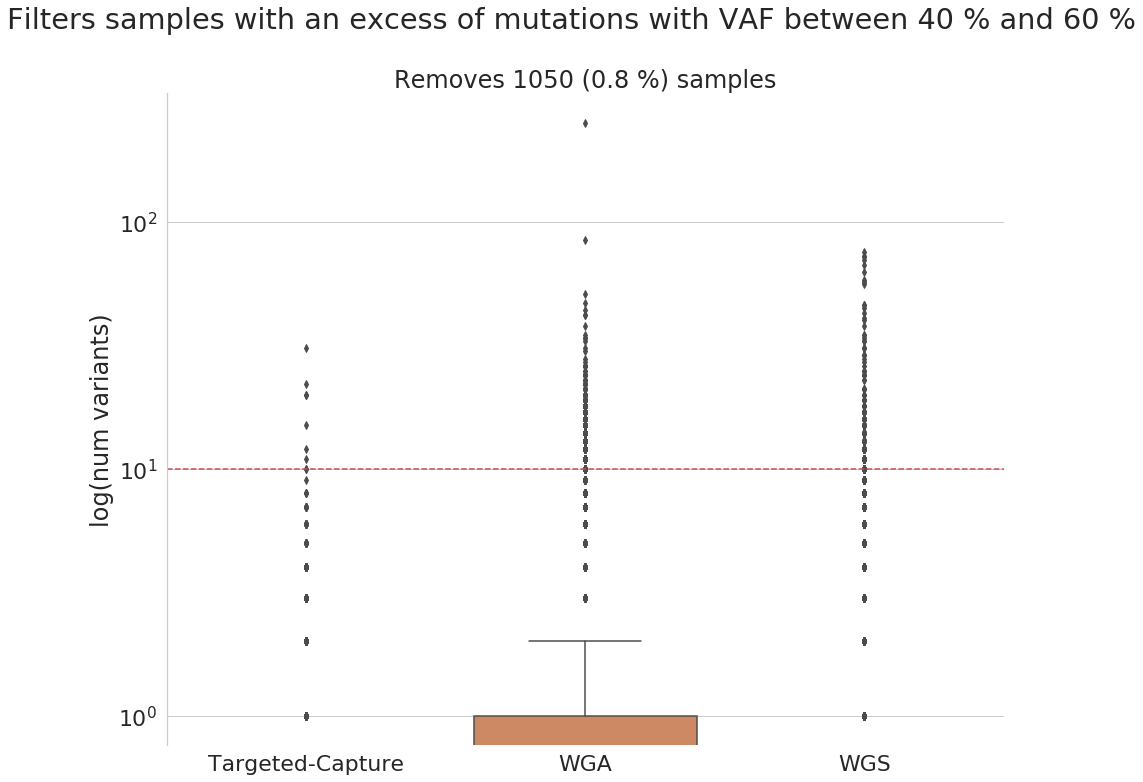

In [30]:
plt.figure(figsize=(15, 12))
sns.boxplot(data=count_variants_per_sample, x='library_strategy', y='variant_id')
plt.yscale('log')
plt.xlabel(None)
plt.ylabel('log(num variants)')
plt.axhline(outlier_thr, c='r', linestyle='--')

plt.suptitle("Filters samples with an excess of mutations with VAF between 40 % and 60 %")
num_filterd_samples = count_variants_per_sample[count_variants_per_sample.variant_id > outlier_thr].shape[0]
plt.title("Removes {} ({} %) samples".format(
    num_filterd_samples, round(float(num_filterd_samples) / num_samples * 100, 2)))
sns.despine(bottom=True)

## Filtering variants

In [31]:
total_variants = variants.shape[0]
dp_thrs = [10, 50, 75, 100, 500]
for thr in dp_thrs:
    count_filtered_variants = variants[variants.dp < thr].shape[0]
    print("Filtered {} ({} %) variants with a depth of coverage threshold of {}x".format(count_filtered_variants, round(float(count_filtered_variants) / total_variants * 100, 2), thr))

Filtered 0 (0.0 %) variants with a depth of coverage threshold of 10x
Filtered 1561951 (6.46 %) variants with a depth of coverage threshold of 50x
Filtered 1789997 (7.4 %) variants with a depth of coverage threshold of 75x
Filtered 2000810 (8.27 %) variants with a depth of coverage threshold of 100x
Filtered 3539185 (14.63 %) variants with a depth of coverage threshold of 500x


In [32]:
af_thrs = [0.01, 0.02, 0.05]
for thr in af_thrs:
    count_filtered_variants = variants[variants.vaf < thr].shape[0]
    print("Filtered {} ({} %) variants with a VAF threshold of {}".format(count_filtered_variants, round(float(count_filtered_variants) / total_variants * 100, 2), thr))

Filtered 16405145 (67.82 %) variants with a VAF threshold of 0.01
Filtered 19600498 (81.03 %) variants with a VAF threshold of 0.02
Filtered 21725174 (89.81 %) variants with a VAF threshold of 0.05


In [33]:
ac_thrs = [5, 10]
for thr in ac_thrs:
    count_filtered_variants = variants[variants.ac < thr].shape[0]
    print("Filtered {} ({} %) variants with a number of supporting reads threshold of {}".format(count_filtered_variants, round(float(count_filtered_variants) / total_variants * 100, 2), thr))

Filtered 5713691 (23.62 %) variants with a number of supporting reads threshold of 5
Filtered 13400570 (55.4 %) variants with a number of supporting reads threshold of 10


### Variants at the extremes of the genome and at homoplasmic positions

In (Sapoval, 2021) they filter out mutations at the extreme of the genome. In particular mutations between positions 1 and 55 and 29804 and 29903.
They also filter homoplasmic positions previously reported in (De Maio, 2020).

The De Maio list is maintained in this repository, we apply the same filtering with the most up to date resource, to find around a 50 % more variants being masked.

In [34]:
variants[variants.variant_type == 'SNV'][['sample', 'variant_id']].groupby('variant_id').count().reset_index().sort_values(by='sample', ascending=False).head(20)

,variant_id,sample
75169,5743:G>C,55810
75172,5744:T>C,54653
63701,29187:C>T,30155
63703,29188:A>G,29247
63210,29039:A>T,29067
78332,6696:C>T,25551
60593,28254:A>C,25437
87657,9502:C>T,25100
49314,24858:G>A,23970
24301,1730:G>A,22229


In [35]:
variants[variants.variant_type == 'INSERTION'][['sample', 'variant_id']].groupby('variant_id').count().reset_index().sort_values(by='sample', ascending=False).head(20)

,variant_id,sample
50765,6696:C>CT,64167
41054,29051:C>CA,51394
38922,28214:C>CT,35987
13057,15965:G>GT,31248
35561,26654:G>GT,29937
4099,11812:C>CA,28223
24043,21101:G>GT,28109
2380,11095:C>CT,27349
1340,10619:C>CA,25645
839,10386:C>CT,22905


In [36]:
variants[variants.variant_type == 'DELETION'][['sample', 'variant_id']].groupby('variant_id').count().reset_index().sort_values(by='sample', ascending=False).head(20)

,variant_id,sample
75401,509:GGTCATGTTATGGTT>G,47447
65061,28987:CCAA>C,36761
75299,507:ATGGTCATGTTATGGT>A,32361
75622,514:TGTTATG>T,29887
81448,7044:CT>C,26301
73302,443:GT>G,23499
85620,8376:CA>C,23183
29354,18606:CT>C,22632
64705,2889:TG>T,19946
62725,28361:GGAGAACGCA>G,19748


In [37]:
sapoval_lower_position = 56
sapoval_upper_position = 29803
variants[(variants.position < sapoval_lower_position) | (variants.position > sapoval_upper_position)].shape[0]

44037

In [38]:
demaio_homoplasmic_positions = [187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700]
variants[(variants.position.isin(demaio_homoplasmic_positions))].shape[0]

82091

In [39]:
problematic_sites = pd.read_csv('problematic_sites_sarsCov2.mask.decomposed.tsv', sep='\t', names=['chromosome', 'position', 'reference', 'alternate'])

specific_problematic = problematic_sites[problematic_sites.alternate != '.']
general_problematic = problematic_sites[problematic_sites.alternate == '.']

bases = ['A', 'C', 'G', 'T']
first_pass = general_problematic.copy()
first_pass.alternate = first_pass.reference.transform(lambda r: bases[0] if r not in [bases[0]] else bases[1])

second_pass = general_problematic.copy()
second_pass.alternate = second_pass.reference.transform(lambda r: bases[1] if r not in bases[0:2] else bases[2])

third_pass = general_problematic.copy()
third_pass.alternate = third_pass.reference.transform(lambda r: bases[2] if r not in bases[0:3] else bases[3])


problematic_sites = pd.concat([specific_problematic, first_pass, second_pass, third_pass]).sort_values('position')

problematic_sites['variant_id'] = problematic_sites[['position', 'reference', 'alternate']].apply(lambda x: "{}:{}>{}".format(x[0], x[1], x[2]), axis=1)
problematic_sites['mask'] = True
problematic_sites.head()

,chromosome,position,reference,alternate,variant_id,mask
0,MN908947.3,1,A,T,1:A>T,True
0,MN908947.3,1,A,G,1:A>G,True
0,MN908947.3,1,A,C,1:A>C,True
1,MN908947.3,2,T,G,2:T>G,True
1,MN908947.3,2,T,C,2:T>C,True


In [40]:
masked_variants = pd.merge(variants, problematic_sites[['variant_id', 'mask']], on='variant_id')
masked_variants[masked_variants['mask']].shape[0]

166571

## Valesano-like filtering

In [41]:
valesano_samples = samples[(samples.read_count >= 50000) & (samples.covered_bases >= 29000)]

In [42]:
valesano_variants = variants[(variants['sample'].isin(valesano_samples.run_accession)) &(variants.vaf >= 0.02) & (variants.vaf < 0.5) & (variants.dp >= 100) & (variants.ac >= 10)]

In [43]:
evaluate_dataset(samples=valesano_samples, variants=valesano_variants)

Samples: 121522
-----
Intrahost mutations: 2017901
Intrahost SNVs: 1602246
Intrahost insertions: 223284
Intrahost deletions: 192371
-----
Unique intrahost mutations: 112267
Unique intrahost SNVs: 76131
Unique intrahost insertions: 5296
Unique intrahost deletions: 30840
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 4.0 [2.0, 10.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 3.0 [1.0, 7.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 2.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 1.0]
-----
Median VAF: 0.035087700933217995
Median AC: 47.0
Median DP: 1273.0
-----
Ratio of NS/S: 2.376
Ratio of in-frame/frameshift: 0.047
Stop loss: 19987
Stop gained: 53143
Start loss: 2024
-----
Variant calling quality: 736.0
SNVs: 669.0
Insertion: 1039.0
Deletion: 990.0
-----
Entropy genomic positions: 307248037093.7

In [44]:
valesano_samples_amplicon = valesano_samples[valesano_samples.library_strategy == "WGA"]

In [45]:
valesano_variants_amplicon = valesano_variants[valesano_variants['sample'].isin(valesano_samples_amplicon.run_accession)]

In [46]:
evaluate_dataset(samples=valesano_samples_amplicon, variants=valesano_variants_amplicon)

Samples: 70982
-----
Intrahost mutations: 1229711
Intrahost SNVs: 961251
Intrahost insertions: 143351
Intrahost deletions: 125109
-----
Unique intrahost mutations: 99188
Unique intrahost SNVs: 68557
Unique intrahost insertions: 4692
Unique intrahost deletions: 25939
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 4.0 [2.0, 8.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 3.0 [1.0, 6.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 1.0 [0.0, 2.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 1.0]
-----
Median VAF: 0.035075001418590546
Median AC: 48.0
Median DP: 1275.0
-----
Ratio of NS/S: 1.976
Ratio of in-frame/frameshift: 0.041
Stop loss: 15761
Stop gained: 22367
Start loss: 662
-----
Variant calling quality: 768.0
SNVs: 709.0
Insertion: 1014.0
Deletion: 968.0
-----
Entropy genomic positions: 185780602185.47214


In [47]:
valesano_samples_wgs = valesano_samples[valesano_samples.library_strategy == "WGS"]

In [48]:
valesano_variants_wgs = valesano_variants[valesano_variants['sample'].isin(valesano_samples_wgs.run_accession)]

In [49]:
evaluate_dataset(samples=valesano_samples_wgs, variants=valesano_variants_wgs)

Samples: 42252
-----
Intrahost mutations: 727277
Intrahost SNVs: 604087
Intrahost insertions: 62124
Intrahost deletions: 61066
-----
Unique intrahost mutations: 76531
Unique intrahost SNVs: 56506
Unique intrahost insertions: 2742
Unique intrahost deletions: 17283
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 5.0 [1.0, 19.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 3.0 [1.0, 16.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 1.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 1.0]
-----
Median VAF: 0.03444559872150421
Median AC: 49.0
Median DP: 1335.0
-----
Ratio of NS/S: 3.319
Ratio of in-frame/frameshift: 0.068
Stop loss: 3988
Stop gained: 29576
Start loss: 440
-----
Variant calling quality: 705.0
SNVs: 632.0
Insertion: 1117.0
Deletion: 1103.0
-----
Entropy genomic positions: 112543381007.15112
SN

In [50]:
valesano_samples_targeted = valesano_samples[valesano_samples.library_strategy == "Targeted-Capture"]

In [51]:
valesano_variants_targeted = valesano_variants[valesano_variants['sample'].isin(valesano_samples_targeted.run_accession)]

In [52]:
evaluate_dataset(samples=valesano_samples_targeted, variants=valesano_variants_targeted)

Samples: 8288
-----
Intrahost mutations: 60913
Intrahost SNVs: 36908
Intrahost insertions: 17809
Intrahost deletions: 6196
-----
Unique intrahost mutations: 13768
Unique intrahost SNVs: 12578
Unique intrahost insertions: 250
Unique intrahost deletions: 940
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 5.0 [2.0, 8.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 1.0 [0.0, 3.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 2.0 [0.0, 4.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 1.0 [0.0, 1.0]
-----
Median VAF: 0.04841149970889092
Median AC: 26.0
Median DP: 606.0
-----
Ratio of NS/S: 2.293
Ratio of in-frame/frameshift: 0.014
Stop loss: 238
Stop gained: 1200
Start loss: 922
-----
Variant calling quality: 372.0
SNVs: 243.0
Insertion: 949.0
Deletion: 517.5
-----
Entropy genomic positions: 8924053901.098007
SNVs: 6135045861.

## Sapoval-like filtering

In [53]:
sapoval_samples = samples[(samples.read_count >= 20000)]

In [54]:
sapoval_variants = variants[(variants['sample'].isin(sapoval_samples.run_accession)) &(variants.vaf >= 0.02) & (variants.vaf < 0.5) & (variants.dp >= 10)]
sapoval_variants = sapoval_variants[~sapoval_variants.position.isin(demaio_homoplasmic_positions)]
sapoval_variants = sapoval_variants[~((sapoval_variants.position < sapoval_lower_position) | (sapoval_variants.position > sapoval_upper_position))]

In [55]:
evaluate_dataset(samples=sapoval_samples, variants=sapoval_variants)

Samples: 127245
-----
Intrahost mutations: 4258145
Intrahost SNVs: 2802086
Intrahost insertions: 899226
Intrahost deletions: 556833
-----
Unique intrahost mutations: 150693
Unique intrahost SNVs: 84748
Unique intrahost insertions: 17875
Unique intrahost deletions: 48070
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 9.0 [4.0, 30.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 5.0 [2.0, 17.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 1.0 [0.0, 4.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 1.0 [0.0, 4.0]
-----
Median VAF: 0.05128210037946701
Median AC: 8.0
Median DP: 206.0
-----
Ratio of NS/S: 2.386
Ratio of in-frame/frameshift: 0.035
Stop loss: 36321
Stop gained: 98884
Start loss: 3879
-----
Variant calling quality: 132.0
SNVs: 229.0
Insertion: 67.0
Deletion: 76.0
-----
Entropy genomic positions: 646642382756.3137


## Tonkin-Hill like filtering

In [56]:
# exclude samples by excess of iSNVs
count_variants_per_sample = pd.merge(variants, samples[['run_accession']], left_on='sample', right_on='run_accession', how='outer')[['run_accession', 'variant_id']].groupby('run_accession').count().reset_index()
excess_mutations_thr = count_variants_per_sample.variant_id.quantile(0.99)
excluded_samples_by_excess_variants = count_variants_per_sample[count_variants_per_sample.variant_id > excess_mutations_thr].run_accession

# exclude samples by excess of high frequency iSNVs, suspicion of co-infection
count_high_variants_per_sample = pd.merge(variants[variants.vaf > 0.4], samples[['run_accession']], left_on='sample', right_on='run_accession', how='outer')[['run_accession', 'variant_id']].groupby('run_accession').count().reset_index()
coinfection_thr = count_high_variants_per_sample.variant_id.median() + (2 * (count_high_variants_per_sample.variant_id.quantile(0.75) - count_high_variants_per_sample.variant_id.quantile(0.25)))
excluded_samples_by_coinfection = count_high_variants_per_sample[count_high_variants_per_sample.variant_id > coinfection_thr].run_accession

tonkin_samples = samples[~(samples.run_accession.isin(excluded_samples_by_excess_variants)) & ~(samples.run_accession.isin(excluded_samples_by_coinfection))]

In [57]:
tonkin_variants = variants[(variants['sample'].isin(tonkin_samples.run_accession)) &(variants.vaf >= 0.05) & (variants.vaf < 0.5) & (variants.dp >= 100) & (variants.ac >= 5)]

In [58]:
evaluate_dataset(samples=tonkin_samples, variants=tonkin_variants)

Samples: 123600
-----
Intrahost mutations: 482245
Intrahost SNVs: 339776
Intrahost insertions: 80857
Intrahost deletions: 61612
-----
Unique intrahost mutations: 73220
Unique intrahost SNVs: 53208
Unique intrahost insertions: 2998
Unique intrahost deletions: 17014
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 2.0 [0.0, 3.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 1.0 [0.0, 2.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 1.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 0.0]
-----
Median VAF: 0.0776699036359787
Median AC: 81.0
Median DP: 922.0
-----
Ratio of NS/S: 2.77
Ratio of in-frame/frameshift: 0.048
Stop loss: 3001
Stop gained: 11916
Start loss: 503
-----
Variant calling quality: 1676.0
SNVs: 1567.0
Insertion: 1891.0
Deletion: 1881.0
-----
Entropy genomic positions: 73560302980.56769
SNVs:

## Conservative filter

Excludes samples:
- Mapped reads >= 50,000
- Horizontal coverage >= 29,000 bp
- Exclude samples above 99th percentile of number of iSNVs
- Exclude samples with an outlier number of iSNVs with VAF > 40% and VAF < 80 %

Exclude variants:
- VAF >= 2%, VAF < 50 %
- DP >= 100
- supporting reads >= 10
- Mask extremes of genome + homoplasmic positions from De Maio, 2020
- indels <= 10 bp

In [59]:
conservative_samples = samples[~(samples.run_accession.isin(excluded_samples_by_excess_variants)) & ~(samples.run_accession.isin(excluded_samples_by_coinfection)) & 
                              (samples.read_count >= 50000) & (samples.covered_bases >= 29000)]

In [65]:
conservative_variants = variants[(variants['sample'].isin(conservative_samples.run_accession)) &(variants.vaf >= 0.02) & (variants.vaf < 0.5) & (variants.dp >= 100) & (variants.ac >= 10)]
#conservative_variants = conservative_variants[~conservative_variants.position.isin(demaio_homoplasmic_positions)]
masked_variants = pd.merge(conservative_variants, problematic_sites[['variant_id', 'mask']], on='variant_id', how='outer')
masked_variants['mask'].fillna(False, inplace=True)
conservative_variants = masked_variants[~masked_variants['mask']]
conservative_variants = conservative_variants[~((conservative_variants.position < sapoval_lower_position) | (conservative_variants.position > sapoval_upper_position))]
conservative_variants = conservative_variants[(conservative_variants.length <= 10) & (conservative_variants.length >= -10)]

In [66]:
evaluate_dataset(samples=conservative_samples, variants=conservative_variants)

Samples: 114416
-----
Intrahost mutations: 1394566
Intrahost SNVs: 1019159
Intrahost insertions: 211146
Intrahost deletions: 164261
-----
Unique intrahost mutations: 104778
Unique intrahost SNVs: 72618
Unique intrahost insertions: 4987
Unique intrahost deletions: 27173
-----
Distribution intrahost mutations per sample (median [lower quartile, upper quartile]): 4.0 [2.0, 9.0]
Distribution intrahost SNVs per sample (median [lower quartile, upper quartile]): 2.0 [1.0, 6.0]
Distribution intrahost insertions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 2.0]
Distribution intrahost deletions per sample (median [lower quartile, upper quartile]): 0.0 [0.0, 1.0]
-----
Median VAF: 0.034246601164340966
Median AC: 46.0
Median DP: 1270.0
-----
Ratio of NS/S: 2.73
Ratio of in-frame/frameshift: 0.035
Stop loss: 8353
Stop gained: 35026
Start loss: 1679
-----
Variant calling quality: 749.0
SNVs: 656.0
Insertion: 1037.0
Deletion: 970.0
-----
Entropy genomic positions: 214115562418.4187